## Importing Libraries

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from typing import Callable
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer
import warnings
warnings.filterwarnings('ignore')

## Loss function

In [9]:
class MSE:
  def __call__(self, pred_y, true_y):
    self.pred_y = pred_y
    self.true_y = true_y
    self.loss = tf.reduce_mean((pred_y-true_y)**2)
    return self.loss
  
  def backward(self):
    gradient = tape.gradient(self.loss, (pred_y-true_y))
    return gradient

## Linear Layer

In [10]:
class Linear(Layer):
  def __init__(self, input_dim: int, num_hidden:int = 1):
    self.weight = tf.Variable(tf.random.uniform((input_dim, num_hidden), -1 ,1), trainable=True)
    self.bias = tf.Variable(tf.zeros([num_hidden]), trainable=True)

  def __call__(self, X):
    self.X = X
    output = tf.matmul(self.X, self.weight) + self.bias
    return output
  
  def backward(self, gradient1, gradient2, tape):
    #print(f'gradient1: {gradient1}, gradient2: {gradient2}')
    self.weights_gradient = tape.gradient(gradient1, self.weight)
    self.bias_gradient = tape.gradient(gradient2, self.bias)
    # self.X_gradient = tf.matmul(gradient, self.weights, transpose_b=True)
    return self.weights_gradient, self.bias_gradient

  def update(self, learning_rate):
    self.weight = tf.Variable(self.weight - learning_rate * self.weights_gradient)
    self.bias = tf.Variable(self.bias - learning_rate * self.bias_gradient)

## Relu activation function

In [11]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = tf.clip_by_value(self.input_, 0, tf.float32.max)
    return self.output

## Defining model

In [12]:
class Model(Layer):
  def __init__(self, input_dim, num_hidden):
    super(Model, self).__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden,2)

  def __call__(self, X):
    l1 = self.linear1(X)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient, tape):
    #print(f'output gradient {output_gradient}')
    linear2_gradient1, linear2_gradient2 = self.linear2.backward(output_gradient, output_gradient, tape)
    #print(f'linear2_gradient 1: {linear2_gradient1}, linear2_gradient2 ; {linear2_gradient2}')
    linear1_gradient1, linear1_gradient2 = self.linear1.backward(linear2_gradient1, linear2_gradient2, tape)
    return linear1_gradient1, linear1_gradient2

  def update(self, learning_rate):
    self.linear2.update(learning_rate)
    self.linear1.update(learning_rate)

## Fit the model

In [13]:
def fit(X, y, model:Callable, loss:Callable, learning_rate, num_epochs):
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  for epoch in range(num_epochs):
    with tf.GradientTape(persistent=True) as tape:
      pred_y = model(X)
      loss_value = loss(pred_y, y)
      if epoch % 5 == 0:
        print(f'Epoch: {epoch}, Loss: {loss_value}')
      #print(loss_value)
      model.backward(loss_value, tape)
    model.update(learning_rate)

## Generate data

In [14]:
no_samples, input_dim, output_dim, learning_rate = 500, 3, 2, 0.01 
X = tf.random.uniform((no_samples, input_dim), -1, 1)

weights_true = tf.transpose(tf.constant([[6, 1, 8],[-3, 1, 3]], dtype=tf.float32))
bias_true = tf.constant([0.5, 1], dtype=tf.float32)
true_y = tf.matmul(X ** 2, weights_true) + tf.matmul(X, weights_true) + tf.transpose(bias_true)
print(f'X:{X.shape}, y:{true_y.shape}, weights:{weights_true.shape}, bias:{bias_true.shape}')

X:(500, 3), y:(500, 2), weights:(3, 2), bias:(2,)


## Plotting the data

In [15]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

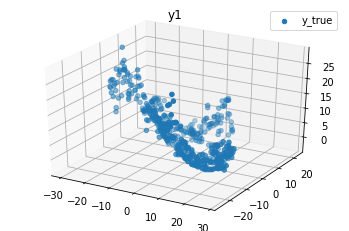

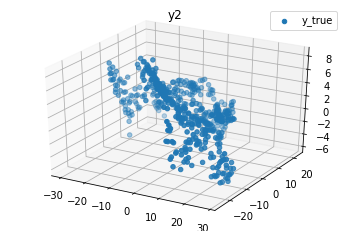

In [16]:
plot_3d('y1', X, true_y[:,0])
plot_3d('y2', X, true_y[:,1])

## Running the model

In [17]:
#running the model for 1 cycle

loss = MSE()
model = Model(input_dim, 10)
pred_y = model(X)
loss_value = loss(pred_y, true_y)

print(f'Loss value: {loss_value}')

Loss value: 41.58140563964844


Epoch: 0, Loss: 41.58140563964844
Epoch: 5, Loss: 38.28836441040039
Epoch: 10, Loss: 34.56216049194336
Epoch: 15, Loss: 30.576692581176758
Epoch: 20, Loss: 26.637996673583984
Epoch: 25, Loss: 23.051925659179688
Epoch: 30, Loss: 20.00871467590332
Epoch: 35, Loss: 17.567169189453125
Epoch: 40, Loss: 15.68962574005127
Epoch: 45, Loss: 14.287978172302246
Epoch: 50, Loss: 13.251517295837402
Epoch: 55, Loss: 12.480236053466797
Epoch: 60, Loss: 11.882946014404297
Epoch: 65, Loss: 11.419814109802246
Epoch: 70, Loss: 11.097253799438477
Epoch: 75, Loss: 10.902044296264648
Epoch: 80, Loss: 10.78895092010498
Epoch: 85, Loss: 10.739006042480469
Epoch: 90, Loss: 10.771849632263184
Epoch: 95, Loss: 10.8622407913208


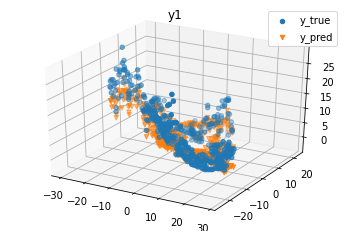

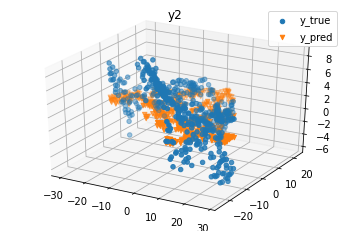

In [18]:
#running for 100 epochs
fit(X, true_y, model=model, loss=loss, learning_rate=learning_rate, num_epochs=100)
pred_y = model(X)
# pred_y = pred_y.detach().numpy()
plot_3d('y1', X, true_y[:, 0], pred_y[:, 0])
plot_3d('y2', X, true_y[:, 1], pred_y[:, 1])